## Monte Carlo simulation for NVT Ensemble

Reference: Computer Simulation of Liquid, 2017

Import packages

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from itertools import product

import sys

All particles are set at the center of a simple square lattice, at the initial state

In [2]:
def initCoords(pos, cells):
    num = len(pos)
    dim = len(pos[0])
    c   = np.zeros(dim)
    gap = 1. / cells

    assert dim == 3, "Wrong dimension, initCoords"

    n = 0
    for i, j, k in product(range(cells[0]), range(cells[1]), range(cells[2]) ):

        c      = np.array([i, j, k]) + 0.5
        c      = c * gap
        c      = c - 0.5
        pos[n] = c
        n      = n + 1

        if n >= num:
            return pos

    return pos


In [3]:
class PotentialType:
    """A compsite variable for interactions."""

    def __init__(self, pot, vir, ovr):
        self.pot = pot # Potential Energy
        self.vir = vir # Virial
        self.ovr = ovr # Check if overlap

    def __add__(self, other):
        pot = self.pot + other.pot
        vir = self.vir + other.vir
        ovr = self.ovr or other.ovr
        return PotentialType(pot, vir, ovr)

    def __sub__(self, other):
        pot = self.pot - other.pot
        vir = self.vir - other.vir
        ovr = self.ovr or other.ovr
        return PotentialType(pot, vir, ovr)


Calculate the interaction between particle $i$ and other particles.
The Lennard-Jones potential is used.

In [4]:
def potential_1( ri, box, r_cut, r ):

    dim      = len(r[0])
    r_cut_sq = r_cut ** 2

    assert dim == 3, "Dimension error for r in potential_1"

    sr2_ovr = 1.77 # Overlap threshold (pot > 100)

    rij      = ri - r
    rij      = rij - np.rint(rij)  # Periodical boundary conditions
    rij      = rij * box
    rij2     = np.sum(rij**2, axis = 1)
    in_range = rij2 < r_cut_sq
    sr2      = np.where(in_range, 1./rij2, 0.)

    ovr = sr2 > sr2_ovr
    if np.any(ovr):
        partial = PotentialType( pot = 0.0, vir = 0.0, ovr = True )
        return partial

    sr6 = sr2 ** 3
    sr12 = sr6 ** 2

    pot = sr12 - sr6
    vir = pot + sr12
    partial = PotentialType ( pot=np.sum(pot), vir=np.sum(vir), ovr=False )

    partial.pot = partial.pot * 4.0          # 4 * epsilon
    partial.vir = partial.vir * 24.0 / 3.0   # 24 * epsilon and divide by 3.0

    return partial

def potential( box, r_cut, r ):
    """
    Calculate the total energy of the system
    """

    dim = len(r[0])
    num = len(r)
    assert dim == 3, "Dimension error for r in potential"

    total = PotentialType ( pot=0.0, vir=0.0, ovr=False )

    for i in range(num-1):
        partial = potential_1 ( r[i,:], box, r_cut, r[i+1:,:] )
        if partial.ovr:
            total.ovr = True
            break
        total = total + partial

    return total



Define some math function

In [5]:
def random_translate_vector ( dr_max, old ):
    zeta = np.random.rand(3)
    zeta = 2.0*zeta - 1.0
    return old + zeta * dr_max

def metropolis ( delta ):
    exponent_guard = 75.0

    if delta > exponent_guard: # Too high, reject without evaluating
        return False
    elif delta < 0.0:
        return True
    else:
        zeta = np.random.rand()
        return np.exp(-delta) > zeta

In [6]:
def MC_NVT(system):

    box = system["size"]
    vol = np.prod(system["size"])
    num = system["numberOfParticles"]
    rho = float(num) / vol

    rCut  = system["rCut"]
    drMax = system["drMax"]
    cells = system["cells"]

    nBlock = system["numberOfBlocks"]
    nStep  = system["numberOfSteps"]

    temperature = system["temperature"]

    r = np.zeros([num, 3])
    r = initCoords(r, cells)

    sr3 = 1.0 / rCut**3
    pressureDelta = np.pi * (8.0/3.0) * ( sr3**3 - sr3 ) * rho**2
    print("pressure delta: " + str(pressureDelta) )
    pressureLrc = np.pi * ( (32./9.) * sr3**3 - (16./3.) * sr3 ) * rho**2
    print("Pressure lrc: " + str(pressureLrc) )
    Ulrc = np.pi * ( (8./9.) * sr3**3 - (8./3.) * sr3 ) * rho
    print("Internal Energy LRC: " + str(Ulrc) )

    # Initial energy and check the particle position
    total = potential ( box, rCut, r )
    assert not total.ovr, "Overlap in the initial configuration"

    total.pot = total.pot + Ulrc * num

    moveRatio = 0.0
    moveRatios = []

    pressures   = []
    totalEnergy = []
    pots        = []

    poss = []

    for block in tqdm(range(nBlock)):

        for step in range(nStep):

            moves = 0

            for i in range(num):

                rj = np.delete(r, i, 0) # Array of all the other particles.
                partial_old = potential_1 ( r[i,:], box, rCut, rj )
                assert not partial_old.ovr, "Overlap in the current configuration"

                ri = random_translate_vector ( drMax/box, r[i,:] )
                ri = ri - np.rint ( ri )

                partial_new = potential_1 ( ri, box, rCut, rj )

                if not partial_new.ovr:
                    delta = partial_new.pot - partial_old.pot
                    delta = delta / temperature

                    if metropolis ( delta ):
                        total  = total + partial_new - partial_old
                        r[i,:] = ri
                        moves  = moves + 1


            # Test Particle Method
            rj = np.random.rand(3) - 0.5
            testParticle = potential_1 ( rj, box, rCut, r )
            if testParticle.ovr:
                pot = 0
            else:
                pot = np.exp( - testParticle.pot / temperature )
            pots.append(pot)
            # End of Test Particle Method

            moveRatio = moves / num
            #pressure = rho * temperature + total.vir / vol + pressureDelta
            pressure = rho * temperature + total.vir / vol + pressureLrc

            if (block > 0) and ( step%20 == 0 ):
                poss.append(r.copy())


            # Test ratio of accepted to attempted moves
            if moveRatio > 0.55:
                drMax *= 1.05
            elif moveRatio < 0.45:
                drMax *= 0.95

            moveRatios.append(moveRatio)
            pressures.append(pressure)
            totalEnergy.append(total)

    total = potential ( box, rCut, r )
    assert not total.ovr, 'Overlap in final configuration'

    total = np.array( [it.pot for it in totalEnergy] )

    return pressures, moveRatios, total, pots, totalEnergy, poss



In [7]:
import build.MonteCarlo as MC

In [8]:
import time

In [9]:
box = np.array( [10, 10, 10] )
vol = np.prod( box )
num = 200
rho = float(num) / vol

rCut  = 2.5
drMax = 0.25
cells = np.ceil( float( num  / np.prod( box ) )**(1./3.) * box )
cells = cells.astype(np.int64)

temperature = 2.

r = np.zeros([num, 3])
r = initCoords(r, cells)

# Initial energy and check the particle position
total = potential ( box, rCut, r )
assert not total.ovr, "Overlap in the initial configuration"

mc = MC.MonteCarlo(num, 3, temperature, rCut, True)
mc.SetBox( box )

# Initial energy and check the particle position, CPP veraion
mc.SetPosition( r )
total1 = mc.GetPotential()

print( "CPP total potential: " + str(total1["pot"]))
print( "Py  total potential: " + str(total.pot))
print( "CPP total Virial: " + str(total1["vir"]))
print( "Py  total Virial: " + str(total.vir))

results = mc.MoveParticles( drMax )
total2  = PotentialType ( pot=results["pot"], vir=results["vir"], ovr= False ) + total

total1 = mc.GetPotential()

r1    = mc.GetPosition()
total = potential ( box, rCut, r1 )

print("********* after displacement particle *********")
print( "CPP total potential: " + str(total1["pot"]))
print( "CPP total potential 2: " + str(total2.pot))
print( "Py  total potential: " + str(total.pot))
print( "CPP total Virial: " + str(total1["vir"]))
print( "CPP total Virial 2: " + str(total2.vir))
print( "Py  total Virial: " + str(total.vir))

CPP total potential: -1952.7392041975813
Py  total potential: -128.72578740940781
CPP total Virial: -3726.969666173017
Py  total Virial: -247.09770963763188
********* after displacement particle *********
CPP total potential: -4184.72793656511
CPP total potential 2: -1244.7201535929166
Py  total potential: -4.493217717972474
CPP total Virial: -3260.900003746638
CPP total Virial 2: -14.062878424451242
Py  total Virial: 94.17869947367441


In [10]:
def MC_NVT_CPP(system, isNeihborList = True):

    box = system["size"]
    vol = np.prod(system["size"])
    num = system["numberOfParticles"]
    rho = float(num) / vol

    rCut  = system["rCut"]
    drMax = system["drMax"]
    cells = system["cells"]

    nBlock = system["numberOfBlocks"]
    nStep  = system["numberOfSteps"]

    temperature = system["temperature"]

    r = np.zeros([num, 3])
    r = initCoords(r, cells)

    sr3 = 1.0 / rCut**3
    pressureDelta = np.pi * (8.0/3.0) * ( sr3**3 - sr3 ) * rho**2
    print("pressure delta: " + str(pressureDelta) )
    pressureLrc = np.pi * ( (32./9.) * sr3**3 - (16./3.) * sr3 ) * rho**2
    print("Pressure lrc: " + str(pressureLrc) )
    Ulrc = np.pi * ( (8./9.) * sr3**3 - (8./3.) * sr3 ) * rho
    print("Internal Energy LRC: " + str(Ulrc) )

    mc = MC.MonteCarlo( num, 3, temperature, rCut, isNeihborList )
    mc.SetBox( box )

    # Initial energy and check the particle position
    mc.SetPosition( r )
    total1 = mc.GetPotential()
    assert not total1["overlap"], "Overlap in the initial configuration"

    """
    total = PotentialType ( pot=total1["pot"], vir=total1["vir"], ovr= (True if total1["overlap"] else False) )
    total.pot = total.pot + Ulrc * num
    """

    time_start = time.time()

    steps = int( nBlock * nStep )

    results = mc.MCrun(steps, drMax)

    totalEnergy = results["potential"] + Ulrc * num
    pressures   = rho * temperature + results["vir"] / vol + pressureLrc
    moveRatios  = results["moveRatios"]

    time_end = time.time()
    print("Running Time: " + str(time_end-time_start) + " s")

    pots = []

    '''
    moveRatios = []
    pressures   = []
    totalEnergy = []
    pots        = []

    moveRatio = 0.0

    for block in tqdm(range(nBlock)):

        for step in range(nStep):

            results = mc.MoveParticles( drMax )
            total  += PotentialType ( pot=results["pot"], vir=results["vir"], ovr= False )

            moves = results["moves"]

            # Test Particle Method
            pot = mc.TestParticles()
            pot = np.exp( - pot / temperature )
            pots.append(pot)
            # End of Test Particle Method

            moveRatio = moves / num
            #pressure = rho * temperature + total.vir / vol + pressureDelta
            pressure = rho * temperature + total.vir / vol + pressureLrc

            # Test ratio of accepted to attempted moves
            if moveRatio > 0.55:
                drMax *= 1.05
            elif moveRatio < 0.45:
                drMax *= 0.95

            moveRatios.append(moveRatio)
            pressures.append(pressure)
            totalEnergy.append(total)
    '''

    total = mc.GetPotential()
    assert not total["overlap"], 'Overlap in final configuration'

    return pressures, moveRatios, totalEnergy, pots


In [11]:
system = {}
system["size"]              = np.array([10, 10, 10])
system["numberOfParticles"] = 400
system["temperature"]       = 2.
system["rCut"]              = 2.5
system["cells"]             = np.ceil( float( system["numberOfParticles"] / np.prod(system["size"]) )**(1./3.) * system["size"] )
system["cells"]             = system["cells"].astype(np.int64)
system["drMax"]             = 0.25
system["numberOfBlocks"]    = 10
system["numberOfSteps"]     = 1000

In [12]:
pressure, moveRatio, totalEnergy, pots = MC_NVT_CPP(system)

pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493
Running Time: 205.06685996055603 s


In [12]:
pressure1, moveRatio1, totalEnergy1, pots1, _, _ = MC_NVT(system)

pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493


100%|██████████| 10/10 [03:45<00:00, 22.57s/it]


In [17]:
print( "CPP Pressure: " + str( np.mean( np.array(pressure[4000:] ) ) ) )
print( "PY  Pressure: " + str( np.mean( np.array(pressure1[4000:]) ) ) )

print( "CPP Total Energy: " + str( np.mean( np.array(totalEnergy[4000: ]) ) ) )
print( "PY  Total Energy: " + str( np.mean( np.array(totalEnergy1[4000:]) ) ) )

CPP Pressure: 0.7062772385976074
PY  Pressure: 0.7003388437765461
CPP Total Energy: -1014.6478115532851
PY  Total Energy: -1014.2558969499868


In [14]:
-127005.16164098663 / 50000 * 400

-1016.041293127893

In [19]:
'''
chemPex = np.mean( np.array(pots[1000:]))
chemPex = - np.log( chemPex )
print( "Excess Chemical Potential: " + str(chemPex) )
chemP = np.log( 0.4 ) + chemPex
print( "Chemical Potential: " + str(chemP) )
'''

Excess Chemical Potential: -0.28058528226276175
Chemical Potential: -1.1968760141369168


In [19]:
testDensity = np.arange(100, 1000, 100)
p1   = []
m1   = []
t1   = []
pot1 = []
#pressure, moveRatio, totalEnergy, pots = MC_NVT(system)
for i in testDensity:
    system["numberOfParticles"] = i
    system["cells"] = np.ceil( float( system["numberOfParticles"] / np.prod(system["size"]) )**(1./3.) * system["size"] )
    system["cells"] = system["cells"].astype(np.int64)
    system["numberOfBlocks"] = 10
    p, m, t, pot, _, _ = MC_NVT(system)
    p1.append(p)
    m1.append(m)
    t1.append(t)
    pot1.append(pot)

pres = [np.mean( np.array(i[2000:]) ) for i in p1]

pressure delta: -0.00533969013773771
Pressure lrc: -0.010694021158401335
Internal Energy LRC: -0.05354331020663623


 10%|█         | 1/10 [00:03<00:35,  3.91s/it]/var/folders/8r/4lys0f3j3s37f6sly02kgnv40000gn/T/ipykernel_6761/118895770.py:15: RuntimeWarning: divide by zero encountered in divide
  sr2      = np.where(in_range, 1./rij2, 0.)
100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


pressure delta: -0.02135876055095084
Pressure lrc: -0.04277608463360534
Internal Energy LRC: -0.10708662041327247


100%|██████████| 10/10 [01:30<00:00,  9.05s/it]


pressure delta: -0.04805721123963938
Pressure lrc: -0.09624619042561199
Internal Energy LRC: -0.16062993061990868


100%|██████████| 10/10 [02:33<00:00, 15.37s/it]


pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493


100%|██████████| 10/10 [03:51<00:00, 23.15s/it]


pressure delta: -0.13349225344344273
Pressure lrc: -0.2673505289600333
Internal Energy LRC: -0.26771655103318115


100%|██████████| 10/10 [05:02<00:00, 30.30s/it]


pressure delta: -0.19222884495855752
Pressure lrc: -0.38498476170244794
Internal Energy LRC: -0.32125986123981737


100%|██████████| 10/10 [06:41<00:00, 40.18s/it]


pressure delta: -0.26164481674914775
Pressure lrc: -0.5240070367616652
Internal Energy LRC: -0.3748031714464536


100%|██████████| 10/10 [08:30<00:00, 51.02s/it]


pressure delta: -0.34174016881521346
Pressure lrc: -0.6844173541376855
Internal Energy LRC: -0.42834648165308986


100%|██████████| 10/10 [10:18<00:00, 61.83s/it]


pressure delta: -0.4325149011567545
Pressure lrc: -0.866215713830508
Internal Energy LRC: -0.4818897918597261


100%|██████████| 10/10 [12:15<00:00, 73.57s/it]


In [36]:
testDensity = np.arange(100, 1000, 100)
p1   = []
m1   = []
t1   = []
pot1 = []
#pressure, moveRatio, totalEnergy, pots = MC_NVT(system)
for i in testDensity:
    system["numberOfParticles"] = i
    system["cells"] = np.ceil( float( system["numberOfParticles"] / np.prod(system["size"]) )**(1./3.) * system["size"] )
    system["cells"] = system["cells"].astype(np.int64)
    system["numberOfBlocks"] = 10
    p, m, t, pot = MC_NVT_CPP(system)
    p1.append(p)
    m1.append(m)
    t1.append(t)
    pot1.append(pot)

pres = [np.mean( np.array(i[2000:]) ) for i in p1]

pressure delta: -0.00533969013773771
Pressure lrc: -0.010694021158401335
Internal Energy LRC: -0.05354331020663623
Running Time: 4.584663152694702 s
pressure delta: -0.02135876055095084
Pressure lrc: -0.04277608463360534
Internal Energy LRC: -0.10708662041327247
Running Time: 18.897969007492065 s
pressure delta: -0.04805721123963938
Pressure lrc: -0.09624619042561199
Internal Energy LRC: -0.16062993061990868
Running Time: 44.167722940444946 s
pressure delta: -0.08543504220380337
Pressure lrc: -0.17110433853442136
Internal Energy LRC: -0.21417324082654493
Running Time: 80.74603796005249 s
pressure delta: -0.13349225344344273
Pressure lrc: -0.2673505289600333
Internal Energy LRC: -0.26771655103318115
Running Time: 127.70517802238464 s
pressure delta: -0.19222884495855752
Pressure lrc: -0.38498476170244794
Internal Energy LRC: -0.32125986123981737
Running Time: 188.2700319290161 s
pressure delta: -0.26164481674914775
Pressure lrc: -0.5240070367616652
Internal Energy LRC: -0.37480317144645

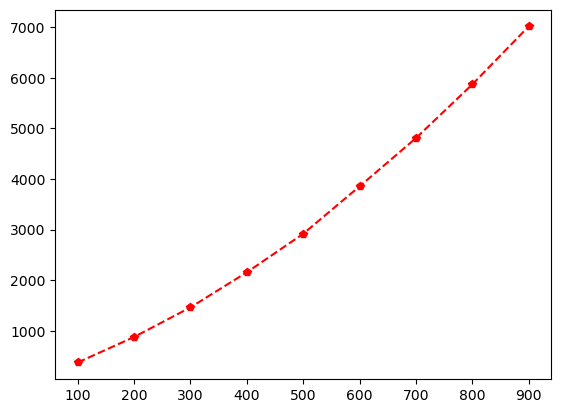

In [317]:
# ytime = np.array( [ 6.16, 14.40, 24.25, 35.58, 48.39, 1.04.16, 1.20.09, 1.37.51, 1.56.55 ] )
h1 = np.array( [ 0, 0, 0, 0, 0, 1, 1, 1, 1 ] )
m1 = np.array( [ 6, 14, 24, 35, 48, 4, 20, 37, 56 ] )
s1 = np.array( [ 16, 40, 25, 58, 39, 16, 9, 51, 55 ] )

yTime = h1 * 3600 + m1 * 60 + s1
xTime = np.arange(100, 1000, 100)

plt.plot(xTime, yTime, color="red", linestyle = "--", marker="p")

Text(0, 0.5, 'Pressure')

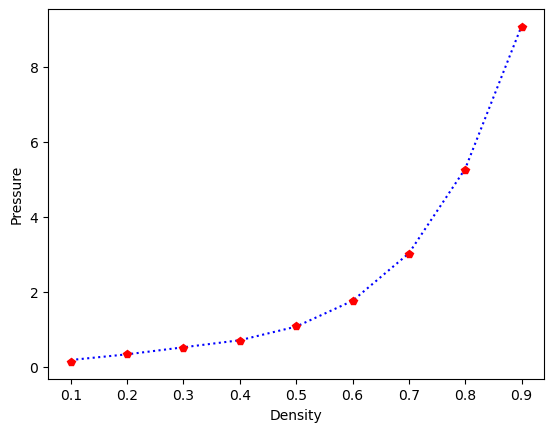

In [37]:
xx1 = np.array([0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
xx2 = np.arange(0.1, 1.0, 0.1)
yy1 = np.array([0.1777, 0.3290, 0.705, 1.069, 1.756, 3.024, 5.28, 9.09])

plt.plot(xx1, yy1, color="b", linestyle=":", marker="")
plt.plot(xx2, pres, color="r", linestyle="", marker="p")

plt.xlabel("Density")
plt.ylabel("Pressure")

# Data from MBWR paper 89 

In [38]:
totU = [
[0.1, -0.669],
[0.2, -1.308],
[0.3, -1.922],
[0.4, -2.539],
[0.5, -3.149],
[0.6, -3.747],
[0.7, -4.3],
[0.8, -4.752],
[0.9, -5.025]
]

totU = np.array( totU )

Text(0, 0.5, 'Energy')

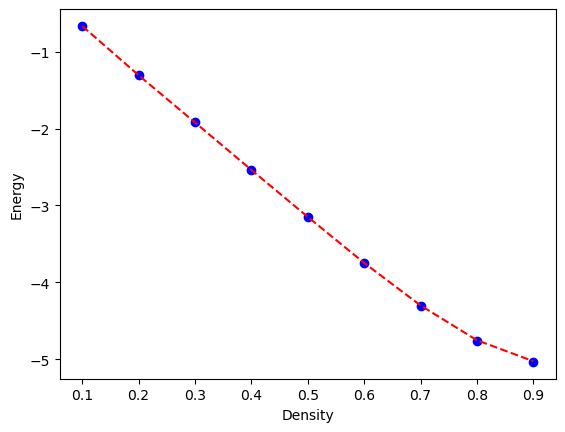

In [39]:
#np.mean( np.array(total[1000:] / 200) )
#total = np.array( [i.pot for i in totalEnergy] )

num = np.arange(100,1000,100)
u   = []
for i, t in enumerate(t1):
    #total = t1 #np.array( [j.pot for j in t] )
    u1 = np.mean( np.array(t[1000:]) ) / num[i]
    u.append(u1)

u = np.array(u)

plt.plot(num/1000, u, color="b", linestyle="", marker="o")
plt.plot(totU[:,0], totU[:,1], color="r", linestyle="--", marker="")

plt.xlabel("Density")
plt.ylabel("Energy")

In [34]:
testChemPex =  [
[0.0015643994119181048, -0.04676014027405717],
[0.0235830983764104, -0.1399367366551898],
[0.054167170524627384, -0.27976527644299587],
[0.08841720712062667, -0.41949834840664124],
[0.10676612292437027, -0.4971455120575854],
[0.13734255764665443, -0.6057242507366922],
[0.16791517365597208, -0.6986780888614508],
[0.19970977781455057, -0.7916001043781549],
[0.2388324921557271, -0.8687062836921857],
[0.27550359277244924, -0.9146263071136254],
[0.29872518632137013, -0.9296465781149568],
[0.32316876801955186, -0.9446350265082337],
[0.3500486885903221, -0.9283100285767016],
[0.3964727821233317, -0.8802260678076124],
[0.4416596126552148, -0.7696743274291791],
[0.4782848887163397, -0.6280955441984197],
[0.5148948899255987, -0.4240171587502619],
[0.5417251672278055, -0.20456845361218345],
[0.5746462917114836, 0.09316386733791227],
[0.5990173178633028, 0.37504852947728207],
[0.6209443677166007, 0.6568695464005456],
[0.6392054531221161, 0.9385950954996467],
[0.6586770705379931, 1.2672271688698515],
[0.6757161677942479, 1.5489208953609],
[0.6915218207623425, 1.8774575009069432],
[0.7109743446133874, 2.2842140770488975],
[0.7206929691129768, 2.5188421662285743],
[0.7291896054633056, 2.7534384328001975],
[0.7437694515691731, 3.097568116292538],
[0.7510479184832074, 3.3165076597017578],
[0.7619694375672255, 3.6292920742612376],
[0.7789550728419501, 4.129734408513183],
[0.7910833052233632, 4.505050247898115],
[0.7959330706907417, 4.661426543873829]
]

testChemPex = np.array( testChemPex )

# data from Frenkel's book

In [30]:
import MBWR_EOS

test = {"temperature": 2.0, "sigma": 1., "component":1, "epsilon":1., "wave":1.0}
CP = []

mbwr = MBWR_EOS.MBWR_EOS(test)
for i in xx2:
    mbwr.rho = i
    chemP = mbwr.exChemicalPotential()
    CP.append(chemP)

CP = np.array( CP )


In [31]:
yy = np.array([ -0.124232,  -0.186052, -0.172991, -0.0584114, 0.244226, 0.771789, 1.7077 ])
xx = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ])

In [53]:
def uTail ( rho, rCut ):
    tail = (8./3.) * np.pi * rho * ( (1./3.) * (1./rCut)**9 - (1./rCut)**3 )
    return tail

tCPex = [ np.mean( np.array( i[2000:] ) ) for i in pot1 ]
tCPex = - np.log( tCPex )

xx2 = np.arange( 0.1, 1, 0.1 )
uts = []
for i in xx2:
    ut = uTail ( i, 2.5 )
    uts.append(ut)

tCPex = tCPex + 2*np.array( uts )

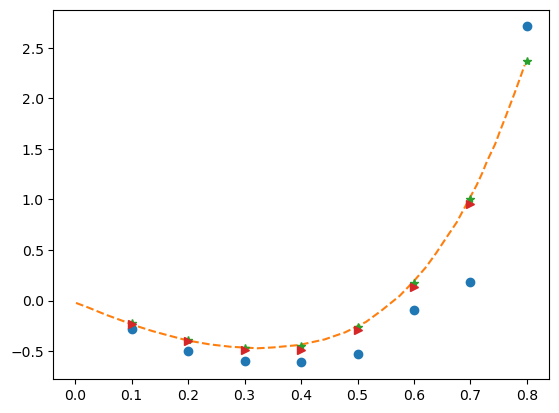

In [54]:
xx2 = np.arange(0.1, 1, 0.1)
plt.plot( xx2[:-1], tCPex[:-1], 'o' )
plt.plot( testChemPex[:,0], testChemPex[:,1]/2., "--")
plt.plot( xx2[:-1], CP[:-1,0,0], '*' )

plt.plot( xx, yy + 2*np.array(uts[:7]), ">" )

1.3267794212016493

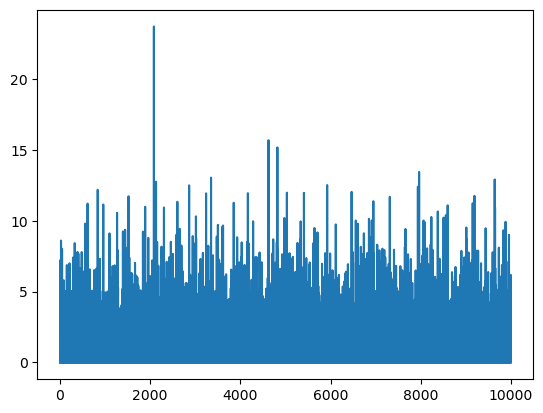

In [55]:
plt.plot(pots)
np.mean(pots)

In [158]:
g_data = np.array([
[0.9053097583917941, 0.09677895709469198],
[0.9266080362185743, 0.284216474484988],
[0.938333714070804, 0.45684809909743507],
[0.9450616873413035, 0.6146665537919591],
[0.9551308969960147, 0.8025949473581164],
[0.9639660801097921, 1.0198522000946943],
[0.9723958015604889, 1.2594994486819941],
[0.9795657692073664, 1.4732905775496652],
[0.9871521326040503, 1.6881453265948847],
[0.997224962452182, 1.883839035047713],
[1.0064567864531933, 2.059785727742694],
[1.016510982412349, 2.2155097443423006],
[1.0332360003651648, 2.406462726816395],
[1.0665458561000984, 2.4876822256175695],
[1.0997508247913292, 2.3439190156763523],
[1.120473914526448, 2.189683339611305],
[1.1411897271214935, 2.019838198088787],
[1.1619028934837847, 1.8443168873090066],
[1.182619588156415, 1.6763638022055758],
[1.2033428984109298, 1.5226011402453006],
[1.2261482057910942, 1.3741959970148303],
[1.2531130550309415, 1.226955511223815],
[1.2863145953297135, 1.0758383994574725],
[1.3278401907396624, 0.9377142380084962],
[1.3735351174157922, 0.8217530109386595],
[1.419250191545844, 0.7490080725320687],
[1.4649800003810038, 0.7078690765806877],
[1.5107165250341374, 0.6811355101837218],
[1.5564642761292578, 0.6784826618478688],
[1.6022200461115106, 0.6930303264128099],
[1.6479811286064896, 0.7189733307745279],
[1.693753537779545, 0.7692120596086172],
[1.7395290542713635, 0.8261159871917645],
[1.785311186345067, 0.8972103379180676],
[1.8310940200713954, 0.9698097335231903],
[1.876879760644309, 1.048644315054851],
[1.9226601887044974, 1.116083556789735],
[1.9684335000023543, 1.168257343325164],
[2.0141965872191165, 1.1985004759120805],
[2.05994995153523, 1.2078879866067833],
[2.1056906861041087, 1.1901846894827348],
[2.1514231010775866, 1.1546358602241118],
[2.1971483992887335, 1.1038215757660343],
[2.2428752010412176, 1.056232387476855],
[2.2886020027937026, 1.0086431991876763],
[2.3343299071431676, 0.9634190814223564],
[2.380064427074518, 0.9323853868001923],
[2.4258026557411676, 0.9093069293946456],
[2.471543490546135, 0.891818638681857],
[2.508972591323648, 0.8877661222357798]
])

# data from Dean Frenkel Understanding molecular simulation, e82 Figure N.6


In [137]:
system = {}

system["numberOfParticles"] = 512
system["density"]           = 0.8442
system["temperature"]       = 1.5043
system["rCut"]              = 2.5
system["cells"]             = np.array([8, 8, 8])
system["size"]              = system["cells"] / ( system["density"] ) ** (1./3.)
system["drMax"]             = 0.25
system["numberOfBlocks"]    = 10
system["numberOfSteps"]     = 1000


In [138]:
print( system["size"] )
print( np.prod(system["cells"]) / np.prod( system["size"] ) )

[8.46463439 8.46463439 8.46463439]
0.8442000000000002


In [139]:
pressure, moveRatio, totalEnergy, pots, positions = MC_NVT(system)

pressure delta: -0.38054564069336366
Pressure lrc: -0.7621346985194898
Internal Energy LRC: -0.45201262476442317


100%|██████████| 10/10 [05:12<00:00, 31.27s/it]


In [156]:
import math

box  = system["size"][0]       # Box must be a cube, in this version
n    = 512                     # number of particles
dr   = 0.02                    # in sigma units
dr   = dr / box                # in box = 1 units

nk   = math.floor( 0.5 / dr )  # Accumulate out to half box length
rMax = nk * dr                 # Actual rMax ( box = 1 units )

h     = np.zeros( nk, dtype=np.int64 )  # Histogram bins initialized to zeros
nStep = 0                               # Counts configurations

pos1 = positions

while True:
    if (nStep >= 1000) or (nStep >= len(pos1)):
        break

    r = np.array( pos1[nStep] )

    nShift = n//2
    for shift in range(nShift):
        rij         = r - np.roll(r, shift+1, axis=0)
        rij         = rij - np.rint(rij)
        rij_mag     = np.sqrt( np.sum(rij**2, axis=1) )
        hist, edges = np.histogram( rij_mag, bins=nk, range=(0.0, rMax) )
        factor      = 1 if n%2==0 and shift == nShift-1 else 2
        h           = h + factor* hist
    nStep = nStep + 1 # Increment configuration counter ready for next time

h_id = ( 4.0 * np.pi * float(n) / 3.0 ) * ( edges[1:nk+1]**3 - edges[0:nk]**3 )
g = h / h_id / ( n*nStep )

edges = edges * box                           # Convert bin edges back to sigma = 1 units
rMid  = 0.5 * ( edges[0:nk] + edges[1:nk+1] ) # Mid points of bins

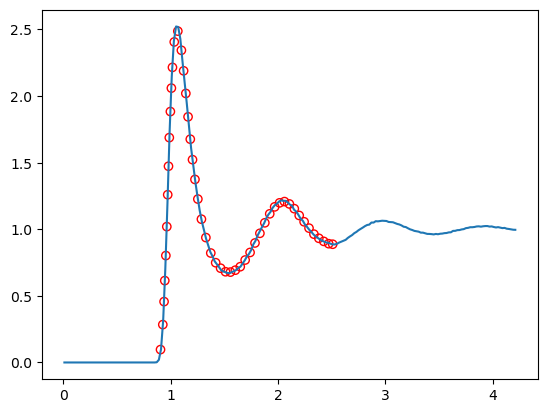

In [163]:
plt.plot( rMid, g )

plt.scatter( g_data[:,0], g_data[:,1], marker="o", edgecolors="r", color='none' )

In [150]:
np.array(positions[100:]).shape

(350, 512, 3)

In [ ]:
"""
1 2 3 4 5 6
6 1 2 3 4 5 (1, 6) (1, 2)
5 6 1 2 3 4 (1, 5) (1, 3)
4 5 6 1 2 3 (1, 4) (1, 4)
"""

"""
1 2 3 4 5
5 1 2 3 4 (1, 5) (1, 2)
4 5 1 2 3 (1, 4) (1, 3)
"""